# Ames Housing Data EDA

This project aims to predict housing prices in Ames, Iowa based on the famous Ames Iowa Housing Dataset from the Ames City Assessor's Office, made available by Dean De Cock of Truman University in 2011. Professor De Cock's original paper can be found [here.](http://jse.amstat.org/v19n3/decock.pdf)

Presentation Slides for this project can be found [here.](https://www.beautiful.ai/player/-N4J5UYshyuRtwl5G4I7)

This notebook includes python code for data extraction, cleaning and transformation. Model Fitting and Analysis code can be found in the Ames_Models notebook.

# Sections and steps

- <a href="#IMP">Reading in Data</a><br>
    
- <a href="#EDA">Exploratory Data Analysis</a><br>
    - <a href="#DV">Sale Price</a><br>
    - <a href="#FP">First Pass - Visualization</a><br>
    - <a href="#MD">Handling Missing Data</a><br>
- <a href="#FEN">Feature Engineering</a><br>
    - <a href="#SP">Second Pass - Analysis</a><br>
        - Land and Exterior
        - House Quality
        - Location
        - Garage
        - Basement
        - Sale Info
        
  - Dropped Features
       - columns with no meaningful difference between categories
       - low correlation
       - Multicollinearity
- <a href="#PRE">Preparing Data for Models</a><br>
    - Linear Models
        -dummify categorical variables
    - Non Linear Models
        -label encode categorical variables
    - All Models
        -split train and validate datasets
        -standardize the numerical variables
- <a href="#EXP">Exporting Cleaned Datasets</a><br>

<p><a name="IMP"></a></p>

## Importing Packages, Reading in Data

In [1]:
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.formula.api import ols
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 12})

#### Importing helper module

In [2]:
#importing helper functions from helper module
from helper_module import * #look_cat, look_num

#### Reading in train data

In [3]:
train = pd.read_csv('./data/raw/train.csv')
train.head()
#train.drop(['Unnamed: 0'], axis=1, inplace=True)
print(f"Read in Ames Housing Train Data - Shape: {train.shape}")

Read in Ames Housing Train Data - Shape: (1460, 81)


#### Reading in test data

In [4]:
test = pd.read_csv('./data/raw/test.csv')
test.head()
#test.drop(['Unnamed: 0'], axis=1, inplace=True)
print(f"Read in Ames Housing Test Data - Shape: {test.shape}")

Read in Ames Housing Test Data - Shape: (1459, 80)


<p><a name="EDA"></a></p>

## Exploratory Data Analysis

### Train Dataset Overview

In [5]:
print('The raw number of features is ', train.shape[1])
print('The raw number of observations is ', train.shape[0])
print('The datattypes are:', train.dtypes.unique())

The raw number of features is  81
The raw number of observations is  1460
The datattypes are: [dtype('int64') dtype('O') dtype('float64')]


 Looking at the codebook, there are several ordinal variables that are coded as numeric. These variables correspond to the following column names:
- MSSubClass
- OverallQual
- OverallCond
- MoSold
- YrSold

Let's make sure these are coded as categorical.

In [6]:
#checking to see how these variables are coded
L = ['MSSubClass', 'OverallQual', 'OverallCond', 'MoSold', 'YrSold', 'GarageYrBlt']
for item in L:
    print(train[item].dtype)

int64
int64
int64
int64
int64
float64


In [7]:
#changing the dtype of these variables to strings
for item in L:
    train[item] = train[item].astype(str)

In [8]:
#selecting just categorical variables in the dataframe and creating a list
cat_var = train.select_dtypes('O').columns.tolist()

#selecting just continuous variables in the dataframe and creating a list
num_var = train.select_dtypes('number').columns.tolist()
num_var.remove('Id')

#creating a list of all variables as an EDA checklist
all_var = train.columns.tolist()
all_var.remove('Id')

print('The number of categorical features is' , len(cat_var))
print('The number of numerical features is', len(num_var))

#Sanity check here
print('The combined numerical and categorical features are', len(cat_var) + len(num_var))
print('Number of Variables left to examine : ', len(all_var))

The number of categorical features is 49
The number of numerical features is 31
The combined numerical and categorical features are 80
Number of Variables left to examine :  80


<p><a name="DV"></a></p>

## Dependent Variable Analysis - Sale Price

In [9]:
#descriptive summary of Sale Price
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

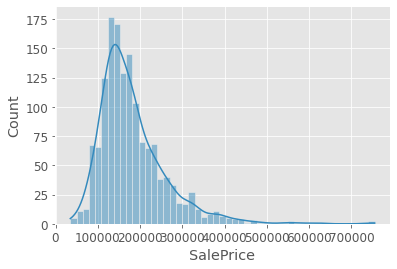

<Figure size 432x288 with 0 Axes>

In [10]:
#plotting a histogram using seaborn
#histogram
sns.histplot(train['SalePrice'], kde = True);
fig = plt.figure()
#TODO - clean up this diagram

Noticing that the dependent variable looks right skewed (aka not normally distributed)

In [11]:
#checking skewness and kurtosis
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


To ensure that the residuals of a linear model taken will be normal, we will take the log of the Sale Price instead of the Sale Price.

In [12]:
#adding a column for log sale price
train['log_SalePrice'] = np.log(train['SalePrice'])

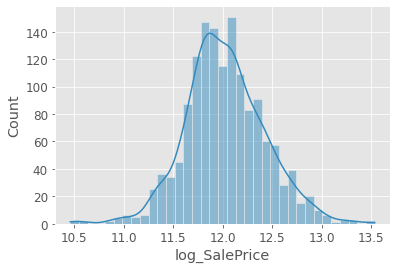

In [13]:
#plotting a histogram using seaborn
#histogram
sns.histplot(train['log_SalePrice'], kde = True);
#TODO - clean up this diagram

In [14]:
#checking skewness and kurtosis
print("Skewness: %f" % train['log_SalePrice'].skew())
print("Kurtosis: %f" % train['log_SalePrice'].kurt())

Skewness: 0.121335
Kurtosis: 0.809532


<p><a name="FP"></a></p>

## Independent Variables Analysis

### First Pass Categorical Features
To get a sense of the independent variables in this dataset, we'll use a helper function to iterate through each categorical variable and look at:
- percentage of missing data
- value counts of observations
- anomalies and outliers
- distribution of variables via barplot and boxplot

No changes will be made to data - this will be saved for feature engineering and selection.

In [15]:
view_cat = look_cat(cat_var)

MSSubClass has 0 missing observations, equal to 0.0%
20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64


<AxesSubplot:xlabel='MSSubClass', ylabel='Log of Sale Price'>

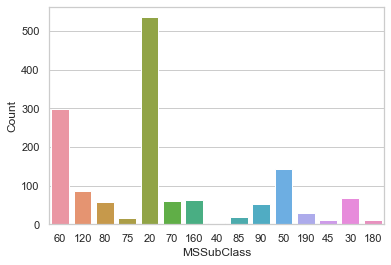

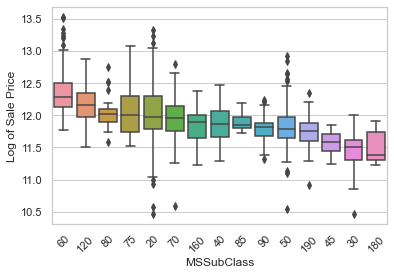

In [16]:
next(view_cat)

#### First Pass Categorical Findings :
1. Variables that are candidates for ANOVA and potential condensing
    - MSSubClass
    - MSZoning
    - LotShape
    - LotConfig
    - LandSlope
    - Neighborhood
    - Condition1
    - RoofStyle
    - Exterior1st
    - Exterior2nd
    - BsmtFinType1
    - Electrical
    - Functional
2. Variables that are candidates for binarization
    - Street --> paved or gravel
    - Alley --> NA is No Alley access
    - LandContour --> Lvl and not lvl
    - Heating --> Mostly Gas A and Other
    - RoofMatl --> Standard Shingle or not
    - GarageType --> Mostly Attached and Other
    - GarageQual --> Mostly TA and Other
    - GarageCond --> Mostly TA and Other
    - PavedDrive --> Mostly Paved and Other
    - Fence --> 80% missing, NA is no fence
    - SaleType --> WD and Other
3. Variables that are candidates to be dropped
    - Utilities --> all obs but one have all Pub Utilities
    - Condition2 --> only 15 obs with conditions
    - PoolQC --> missing data for 99.52% of obs
    - MiscFeature --> missing 96% of obs, NA is no misc feature
4. Other
    - Bldg Type --> Twnhs should be TwnhsI
    - Def want to keep OverallQual
    - Keep ExterQual
    - BsmtQual --> NA is no basement, 37 missing values
    - Same for BsmtCond --> Na is no basement
    - BsmtExposure --> 38 missing
    - BsmtFintype 1 and 2 have missing vals -
    - Electrical has 1 missing val
    - Keep Kitchen Qual
    - Fireplace Quality has 690 missing obs --> na is no fireplace
    - Garage Type --> Na is no garage
    - MoSold to potential Season?
        
        

### First Pass Continunous Features
To get a sense of the idependent variables in this dataset, we'll use a helper function to iterate through each categorical variable and look at:
- missing data
- anomalies and outliers
- pearson's correlation with dependent variable
- distribution via histogram and scatterplot

No changes will be made to data - this will be saved for feature engineering and selection.

In [17]:
view_num = look_num(num_var)

LotFrontage has 259 missing observations, equal to 17.74%
count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64


<AxesSubplot:xlabel='LotFrontage', ylabel='Log of Sale Price'>

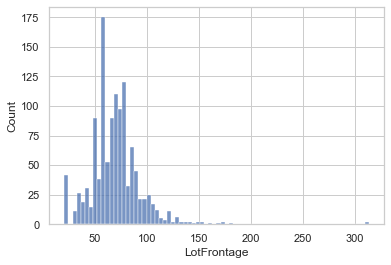

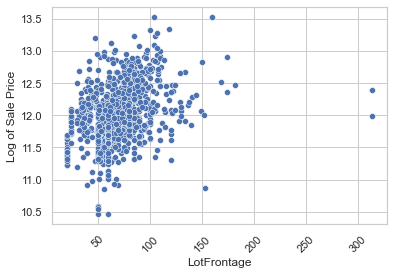

In [18]:
next(view_num)

### Looking into Multicollinearity among Continuous Features

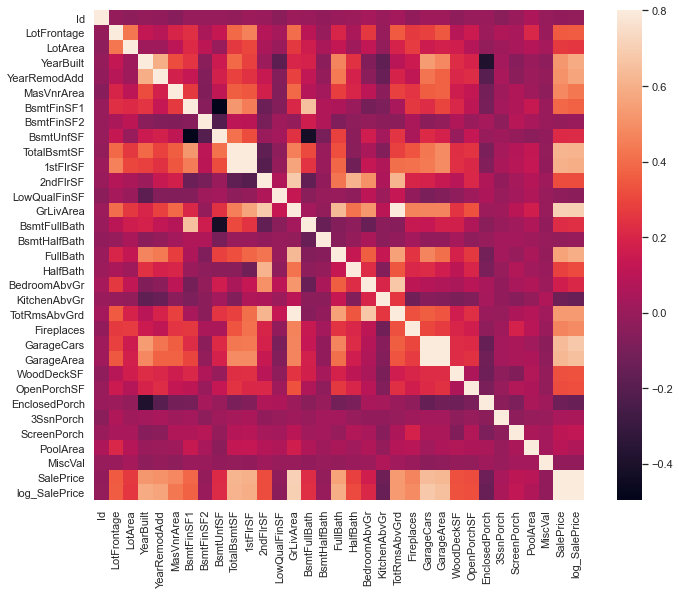

In [19]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

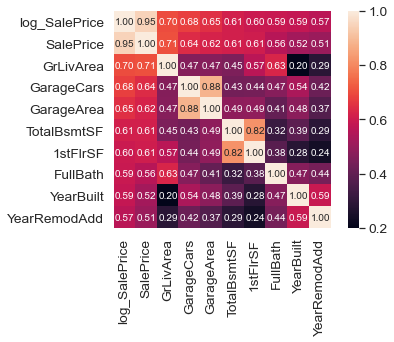

In [20]:
#log_saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'log_SalePrice')['log_SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

#### First Pass Continuous Features Findings:
1. Missingness
    - Lot Frontage : Linear feet of street connected to property
        -Check to see if condos? or high density dwelling?
    - MasVnrArea has 8 missing
2. Outliers
    - LotArea has big outliers
    - BsmtFinSF1 has one potential outlier
    - BedroomAbvGr has one potential outlier of 8
3. Possible feature Engineering
    - Years Since Remodel/Age of Home
    - Number of Bathrooms
    - PoolArea to binary?
4. Possible Drops
    - Garage Area (multicollinearity with GarageCars, but GarageCars has higher correlation with log_SalePrice)
    - One of TotalBsmtSF and 1stFlrSF - Multicollinearity
5. Other
      - Keep GrLivArea

<p><a name="MD"></a></p>


## Handling Missing Data

First pass look at Independent Variables showed several variables with missing values. We will look at each.

In [21]:
#Making a table with the number and percentages of missing observations
num = train.isnull().sum().sort_values(ascending=False)
pct = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
df_md = pd.concat([num, pct], axis=1, keys=['Number', 'Percent'])

#filtering for only the variables where there is 1 or more missing observations
df_md.columns
df_md.loc[df_md.Number > 0]

,Number,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479


For features with more than 80% of observations missing, we will likely drop them from the analysis.

In [22]:
# initializing list of features to drop
col_to_drop = ['PoolQC', 'MiscFeature', 'Alley', 'Fence']

In [23]:
# Double checking codebook before we drop
for feat in col_to_drop:
    print(feat)
    print(train[feat].value_counts())

PoolQC
Gd    3
Ex    2
Fa    2
Name: PoolQC, dtype: int64
MiscFeature
Shed    49
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64
Alley
Grvl    50
Pave    41
Name: Alley, dtype: int64
Fence
MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64


In [25]:
# choosing not to drop Fence, instead impute NA to 0, and make binary variable
col_to_drop.remove('Fence')
col_to_binary = ['Fence']

#imputing 0 for no fence
train['Fence'].fillna(0, inplace=True)
#replacing all obs with fences with 1
train.loc[train.Fence != 0, 'Fence'] = 1

#double checking
train['Fence'].value_counts()

In [30]:
#Looking at FireplaceQu
#data description says NA fireplace means no fireplace
train['FireplaceQu'].fillna('None', inplace=True)

None    690
Gd      380
TA      313
Fa       33
Ex       24
Po       20
Name: FireplaceQu, dtype: int64

In [40]:
#Looking at LotFrontage
#trying to see if these homes maybe don't have any street
#maybe high density aka condos or apartments?
train[train['LotFrontage'].isnull()]['MSZoning'].value_counts()


RL    229
RM     19
FV      8
RH      3
Name: MSZoning, dtype: int64

In [41]:
#trying again, with type of dwelling
train[train['LotFrontage'].isnull()]['MSSubClass'].value_counts()

20     99
60     69
80     20
120    20
50     16
160     8
85      6
30      6
90      5
70      5
190     3
75      1
40      1
Name: MSSubClass, dtype: int64

In [50]:
#trying again with lot configuration
train[train['LotFrontage'].isnull()]['LotConfig'].value_counts()

Inside     134
Corner      62
CulDSac     49
FR2         14
Name: LotConfig, dtype: int64

In [51]:
#comparing this with value counts of lot config across dataset
train.LotConfig.value_counts()

Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64

In [57]:
#trying again with lot area
train[train['LotFrontage'].isnull()]['LotArea'].value_counts()

2117     3
4426     3
7750     3
11250    3
12342    2
        ..
13006    1
32463    1
10448    1
12546    1
15870    1
Name: LotArea, Length: 235, dtype: int64

In [62]:
train['LotFrontage'].describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [49]:
train.loc[train['MSSubClass'] == 20]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,log_SalePrice


In [ ]:
train.loc[train.Fence != 0, 'Fence'] = 1

In [ ]:
train['Fence'].replace('GdPrv', 1, inplace = True)

In [ ]:
# Looking into Fireplace Quality

<p><a name="SP"></a></p>


## Second Pass Looking at Independent Variables
It seems like the independent variables in this dataset fall broadly into these 'buckets':
- Land and Exterior - neighborhood, lot and land characteristics
- House Quality, Construction and Utilities- year built, types of materials used and quality
- Indoor Areas
- Basement
- Semi-Indoor Areas - Garage, Porches, Pool, Fence
- Sale Information - month, year, type of sale etc

Since the patterns of missing data also seem to fall into 'buckets', in our in-depth pass, we will look at variables by these buckets.

In [ ]:
#Initializing two lists - for columns to drop and rows to drop
row_drop = []
col_drop = []

In [ ]:
#Bucketing variables into lists
Location = ['MSSubClass','MSZoning', 'MSZoning','LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2']
HouseQual = ['BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt','YearRemodAdd', 'RoofStyle','RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'Utilities', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical']
Basement = ['BsmtQual','BsmtCond','BsmtExposure', 'BsmtFinType1','BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']
IndoorA = ['1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu']
GaragePlus = ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond','PavedDrive','WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'log_SalePrice']
SaleInfo = ['MoSold','YrSold','SaleType', 'SaleCondition', 'log_SalePrice']

In [ ]:
#initializing an iterator to help bucket variables
#call_var = iter(all_var)
#next(call_var)

In [ ]:
#Sanity Check to make sure I got all the variables, minus our dependent variable - looking for 80
bucketlist = [Location, HouseQual, Basement, IndoorA, GaragePlus, SaleInfo]
temp_ = 0
for L in bucketlist:
    temp_ += len(L)
temp_

# Garage

In [ ]:
df_g = train[Garage]
print(df_g.columns)

#Missing Values
df_g.isna().sum()

From Data Description -> Na is No Garage, so we will impute 

## PorchPlus


In [ ]:
df_pp = train[PorchPlus]
df_pp.columns

In [ ]:
#Missing Values
df_sale.isna().sum()

In [ ]:
#correlation matrix
corrmat = df_pp.corr()
f, ax = plt.subplots(figsize=(6, 8))

k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'log_SalePrice')['log_SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## Sale Info

In [ ]:
df_sale = train[SaleInfo]

In [ ]:
df_sale.head()

In [ ]:
#Missing Values
df_sale.isna().sum()

In [ ]:
#correlation matrix
corrmat = df_sale.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [ ]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [ ]:
## Looking into number of missing values
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Number Missing', 'Percent Missing'])
missing_data.head(29)

In [ ]:
train['PoolQC'].isnull().sum()

### Summary of Data Cleaning

#### Data Imputation
PoolQC --> 1453 NA imputed to 0 for no pool

#### Handling Outliers and Anomalies

#### Categorical Features - box plot, bar plot, ANOVA

#### Quantitative Features - correlation matrix, histogram

### Summary of obs dropped, and vars flagged for feature engineering
- 4 observations dropped - outliers in gr liv area

#### Variables flagged for feature engineering

#### Looking into Multicollinearity

In [ ]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [ ]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

<p><a name="FEN"></a></p>

## Feature Engineering

### Feature Engineering

Previously modified features:-

Sale Price -> Log of Sale Price

#### Land and Exterior

#### House Quality

#### Location

#### Garage

#### Basement

#### Sale Info

### Dropped Features

#### Columns with no meaningful difference between categories

#### Low correlation

#### Multicollinearity

#### Administrative Columns

<p><a name="PRE"></a></p>

## Preprocessing Data for Models

### Linear Models
#### Dummification of Categorical Variables

#### Testing Assumptions for Linear Models

### Non Linear Models
#### Label Encoding of Categorical Variables

### All Models
#### Standardization of numerical variables
#### Split train and validate datasets

<p><a name="EXP"></a></p>

## Exporting Cleaned Datasets

In [ ]:
train.to_csv('./data/cleaned/train_c.csv')

# LE TESTING AREA! DO NOT ENTER

In [ ]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent Missing'])
missing_data.head(25)

In [ ]:
train.isnull().sum().sort_values(ascending=False)

In [ ]:
print(covariance)

In [ ]:
from scipy.stats import pearsonr
corr = pearsonr(train['LotArea'],train['SalePrice'])

In [ ]:
print('Pearsons correlation:', corr[0])

In [ ]:
round(corr[0],3)

In [ ]:
round(corr[1],5)